In [4]:
import scipy.io.wavfile as wav
import numpy as np

# Function to convert stereo audio to mono
def stereo_to_mono(audio_data):
    return audio_data.mean(axis=1)

# Function to apply a PEQ filter
def apply_peq_filter(signal, fs, fc, fbw, g):
    T = 1 / fs
    wc = 2 * np.pi * fc
    wbw = 2 * np.pi * fbw
    wcd = (2 / T) * np.tan(wc * (T / 2))
    Q = wcd / wbw

    # Input coefficients
    a0 = 4 + 2 * (g / Q) * wcd * T + (wcd * T) ** 2
    a1 = 2 * (wcd * T) ** 2 - 8
    a2 = 4 - 2 * (g / Q) * wcd * T + (wcd * T) ** 2

    # Output coefficients
    b0 = 4 + 2 * (1 / Q) * wcd * T + (wcd * T) ** 2
    b1 = -(2 * (wcd * T) ** 2 - 8)
    b2 = -(4 - 2 * (1 / Q) * wcd * T + (wcd * T) ** 2)

    filtered_signal = np.zeros(len(signal))
    for s in range(2, len(signal)):
        filtered_signal[s] = (1 / b0) * ((a0 * signal[s] + a1 * signal[s - 1] + a2 * signal[s - 2]) + (b1 * filtered_signal[s - 1] + b2 * filtered_signal[s - 2]))

    return filtered_signal

# Read WAV file
fs, data = wav.read(r'C:\Users\kalin\Desktop\IIR_Filter_Basics\1.wav')

# Convert to mono if stereo
if data.ndim > 1:
    data = stereo_to_mono(data)

# Apply PEQ1 filter
fc1 = 3500  # Hz
fbw1 = 500  # Hz
g1 = 100     # Gain
peq1_filtered = apply_peq_filter(data, fs, fc1, fbw1, g1)

# Apply PEQ2 filter
fc2 = 100   # Hz
fbw2 = 100   # Hz
g2 = 0.1   # Gain
peq2_filtered = apply_peq_filter(data, fs, fc2, fbw2, g2)

# Write the processed audio back to new WAV files
wav.write(r'C:\Users\kalin\Desktop\IIR_Filter_Basics\output1.wav', fs, np.int16(peq1_filtered))
wav.write(r'C:\Users\kalin\Desktop\IIR_Filter_Basics\output2.wav', fs, np.int16(peq2_filtered))


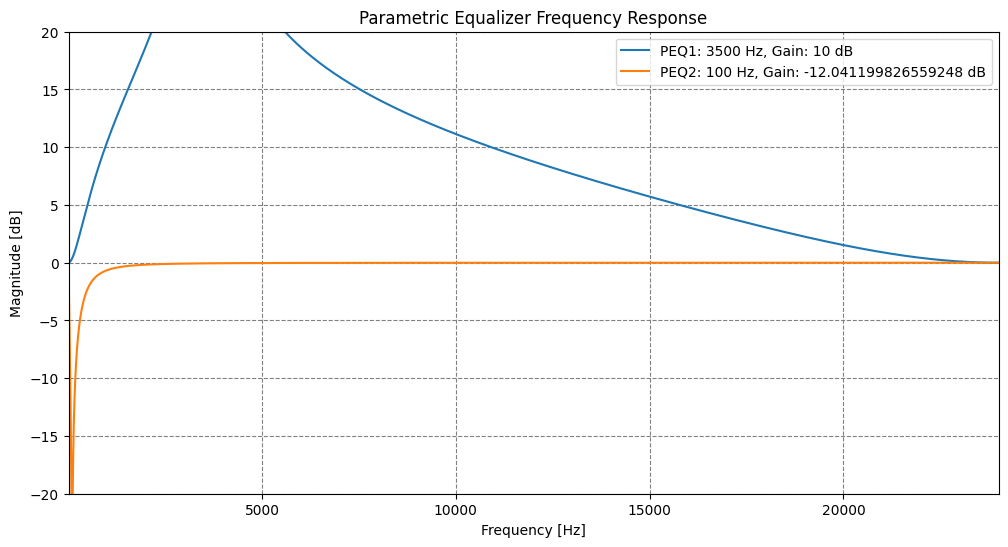

In [5]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

# Set the sample rate
fs = 48000

# Filter parameters, assumed Q values as they are not provided
fc1 = 3500  # Center frequency for PEQ1
g1 = 10     # Gain for PEQ1
Q1 = 1      # Assumed quality factor for PEQ1

fc2 = 100   # Center frequency for PEQ2
g2 = 0.25   # Gain for PEQ2 (attenuation, hence < 1)
Q2 = 1      # Assumed quality factor for PEQ2

# Function to create a parametric EQ filter
def peq_transfer_function(fc, g, Q, fs):
    # Angular frequency
    omega_c = 2 * np.pi * fc / fs
    alpha = omega_c / (2 * Q)

    # Filter coefficients
    b0 = 1 + alpha * g
    b1 = -2 * np.cos(omega_c)
    b2 = 1 - alpha * g
    a0 = 1 + alpha / g
    a1 = -2 * np.cos(omega_c)
    a2 = 1 - alpha / g
    
    # Normalize the coefficients
    b = np.array([b0, b1, b2]) / a0
    a = np.array([a0, a1, a2]) / a0
    
    return b, a

# Calculate the coefficients for both filters
b1, a1 = peq_transfer_function(fc1, g1, Q1, fs)
b2, a2 = peq_transfer_function(fc2, g2, Q2, fs)

# Generate frequency response for both filters
f1, h1 = signal.freqz(b1, a1, worN=fs//2, fs=fs)
f2, h2 = signal.freqz(b2, a2, worN=fs//2, fs=fs)

# Plotting the frequency response
plt.figure(figsize=(12, 6))
plt.plot(f1, 20 * np.log10(abs(h1)), label=f'PEQ1: {fc1} Hz, Gain: {g1} dB')
plt.plot(f2, 20 * np.log10(abs(h2)), label=f'PEQ2: {fc2} Hz, Gain: {20 * np.log10(g2)} dB')
plt.title('Parametric Equalizer Frequency Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.legend()
plt.grid(which='both', linestyle='--', color='grey')
plt.axis([10, fs/2, -20, 20])  # Set frequency range and dB limits
plt.show()

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, freqz

# Define the sampling frequency and the frequencies of interest for the crossover filters
fs = 2 * np.pi  # Use a normalized frequency for analog filters (rad/s)
low_cutoff = 40  # The cutoff frequency for the low-pass filter (woofer) in Hz
mid_cutoff = 120  # The cutoff frequency for the band-pass filter (midrange) in Hz
high_cutoff = 20400  # The cutoff frequency for the high-pass filter (tweeter) in Hz

# Create a logarithmically spaced frequency array over which we'll compute the filter response
freqs = np.logspace(1, 5, 500)  # Frequencies from 10 Hz to 100 kHz

# Butterworth filter order
# The slope of the filter response is determined by the order. A 2nd order is a common choice for crossovers.
n = 2

# Define Butterworth filters for each speaker component
# Low-pass filter for the woofer
b_low, a_low = butter(n, low_cutoff / (fs/2), btype='low', analog=False)
w_low, h_low = freqz(b_low, a_low, worN=freqs, fs=fs)

# Band-pass filter for the midrange (consisting of a low-pass and a high-pass filter)
b_mid_low, a_mid_low = butter(n, low_cutoff / (fs/2), btype='high', analog=False)
b_mid_high, a_mid_high = butter(n, mid_cutoff / (fs/2), btype='low', analog=False)

# We'll combine these two to create the band-pass response
w_mid_low, h_mid_low = freqz(b_mid_low, a_mid_low, worN=freqs, fs=fs)
w_mid_high, h_mid_high = freqz(b_mid_high, a_mid_high, worN=freqs, fs=fs)
h_mid = h_mid_low * h_mid_high  # Multiply the responses to get the band-pass

# High-pass filter for the tweeter
b_high, a_high = butter(n, high_cutoff / (fs/2), btype='high', analog=False)
w_high, h_high = freqz(b_high, a_high, worN=freqs, fs=fs)

# Plot the filter responses
plt.figure(figsize=(12, 6))

# Plot the amplitude response of the low-pass filter
plt.semilogx(w_low, 20 * np.log10(abs(h_low)), label='Low-Pass Filter (Woofer)')

# Plot the amplitude response of the band-pass filter
plt.semilogx(w_mid_low, 20 * np.log10(abs(h_mid)), label='Band-Pass Filter (Midrange)')

# Plot the amplitude response of the high-pass filter
plt.semilogx(w_high, 20 * np.log10(abs(h_high)), label='High-Pass Filter (Tweeter)')

# Add labels and title
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.title('3-Way Crossover System Response')
plt.grid(which='both', linestyle='-', color='grey')
plt.legend()

# Show the plot
plt.show()


ValueError: Digital filter critical frequencies must be 0 < Wn < 1